# Homework 4 - Autoencoder
***Author: Christopher Wagner***

In [1]:
# Import libraries...
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import feature_column

### Multi Class Mappings

In [8]:
# Map the labels to 8 classes
label_class_map = {
    "DDoS-RSTFINFlood": "DDoS",
    "DDoS-PSHACK_Flood": "DDoS",
    "DDoS-SYN_Flood": "DDoS",
    "DDoS-UDP_Flood": "DDoS",
    "DDoS-TCP_Flood": "DDoS",
    "DDoS-ICMP_Flood": "DDoS",
    "DDoS-SynonymousIP_Flood": "DDoS",
    "DDoS-ACK_Fragmentation": "DDoS",
    "DDoS-UDP_Fragmentation": "DDoS",
    "DDoS-ICMP_Fragmentation": "DDoS",
    "DDoS-SlowLoris": "DDoS",
    "DDoS-HTTP_Flood": "DDoS",
    
    "DoS-UDP_Flood": "DoS",
    "DoS-SYN_Flood": "DoS",
    "DoS-TCP_Flood": "DoS",
    "DoS-HTTP_Flood": "DoS",
    
    "Mirai-greeth_flood": "Mirai",
    "Mirai-greip_flood": "Mirai",
    "Mirai-udpplain": "Mirai",
    
    "Recon-PingSweep": "Recon",
    "Recon-OSScan": "Recon",
    "Recon-PortScan": "Recon",
    "VulnerabilityScan": "Recon",
    "Recon-HostDiscovery": "Recon",
    
    "DNS_Spoofing": "Spoofing",
    "MITM-ArpSpoofing": "Spoofing",
    
    "BenignTraffic": "Benign",
    
    "BrowserHijacking": "Web",
    "Backdoor_Malware": "Web",
    "XSS": "Web",
    "Uploading_Attack": "Web",
    "SqlInjection": "Web",
    "CommandInjection": "Web",
    
    "DictionaryBruteForce": "BruteForce"   
}

# Map the labels to 8 classes
# classes = ['Benign', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Web', 'BruteForce']
classes = ['Benign', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing']

def map_label_to_number(y: pd.Series):
    """Maps the labels to 8 numeric classes.

    Args:
        y (pd.Series): The current labels. 

    Returns:
        list: The new labels.
    """
    return [classes.index(label_class_map[label]) for label in y]

def map_number_to_class(y: pd.Series):
    """Maps the 8 numeric classes to their respective labels.

    Args:
        y (pd.Series): The current labels. 

    Returns:
        list: The new labels.
    """
    return [classes[label] for label in y]

### Import Dataset

In [5]:
# Using smaller dataset for testing purposes, has 1_048_575 rows
DATASET_FILE = "../datasets/IoT_Intrusion.csv"
df = pd.read_csv(DATASET_FILE)

# Rename columns
df.rename(columns={
    "Protocol Type": "Protocol_Type",
    "Tot sum": "Tot_sum",
    "Tot size": "Tot_size",
    "label": "target"
}, inplace=True)

# Remove rows with the 
classes_to_remove = [ "BrowserHijacking", "Backdoor_Malware", "XSS", "Uploading_Attack", "SqlInjection", "CommandInjection", "DictionaryBruteForce" ]
df = df[~df.target.isin(classes_to_remove)]

df.shape

(1047713, 47)

In [9]:
# Define the features and target columns
X_columns = df.columns.to_list()[:-1]
y_column = 'target'

X = df[X_columns]
y = df[y_column]

# Map the target column to numerical values
y = map_label_to_number(y)

# print headers
print(df.columns)

Index(['flow_duration', 'Header_Length', 'Protocol_Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot_sum', 'Min', 'Max', 'AVG', 'Std', 'Tot_size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'target'],
      dtype='object')


In [10]:
data_counts = {
    "dataset": pd.Series(map_number_to_class(y)).value_counts().to_list(),
}
print(pd.DataFrame(data_counts, index=classes))

          dataset
Benign     763525
DDoS       181481
DoS         59233
Mirai       24476
Recon       11053
Spoofing     7945


### Split the Dataset into Training and Test Sets

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2)

# Print the basic statistics of the training set
data_counts = {
    "train": pd.Series(map_number_to_class(y_train)).value_counts().to_list(),
    "test": pd.Series(map_number_to_class(y_test)).value_counts().to_list(),
    "validation": pd.Series(map_number_to_class(y_val)).value_counts().to_list(),
    "total": pd.Series(y).value_counts().to_list(),
}
print(pd.DataFrame(data_counts, index=classes))

           train    test  validation   total
Benign    611108  121883       30534  763525
DDoS      144999   29199        7283  181481
DoS        47295    9583        2355   59233
Mirai      19583    3926         967   24476
Recon       8809    1766         478   11053
Spoofing    6376    1277         292    7945


### Pre-Process the Data

In [12]:
# Standardize the data
ss = StandardScaler(copy=True, with_mean=True, with_std=True)

# Fit the scaler on the training data
ss.fit(X_train)

# Transform the training, validation, and testing data
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
X_val = ss.transform(X_val)

# Convert the data into dataframes
train_df = pd.DataFrame(X_train, columns=X_columns).assign(target=y_train)
val_df = pd.DataFrame(X_val, columns=X_columns).assign(target=y_val)
test_df = pd.DataFrame(X_test, columns=X_columns).assign(target=y_test)

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    """Converts a dataframe to a dataset.

    Args:
        dataframe (DataFrame): The dataframe to convert. 
        shuffle (bool, optional): Enables whether the dataset should be shuffled. Defaults to True.
        batch_size (int, optional): Determines the batch size of the dataset. Defaults to 32.

    Returns:
        tf.data.Dataset: The converted dataset.
    """
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

# Convert the dataframes into datasets
train_ds = df_to_dataset(train_df)
val_ds = df_to_dataset(val_df, shuffle=False)
test_ds = df_to_dataset(test_df, shuffle=False)

# Convert the X columns into numeric feature columns
feature_columns = [feature_column.numeric_column(feature) for feature in X_columns]

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


### Autoencoder

In [13]:
class AutoencoderMLP(tf.keras.Model):
    def __init__(self, feature_columns):
        super(AutoencoderMLP, self).__init__()
        
        # Input layer using DenseFeatures
        self.input_layer = tf.keras.layers.DenseFeatures(feature_columns)
        
        self.encoder = tf.keras.Sequential([
            self.input_layer,
            
            tf.keras.layers.Dense(32, activation="tanh"),
            tf.keras.layers.Dense(16, activation="tanh"),
            tf.keras.layers.Dense(8, activation="tanh"),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation="tanh"),
            tf.keras.layers.Dense(32, activation="tanh"),
            tf.keras.layers.Dense(len(feature_columns), activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Define the early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Instantiate the Autoencoder
autoencoder_mlp = AutoencoderMLP(feature_columns)

# Train the Autoencoder
autoencoder_mlp.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
autoencoder_mlp.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stop])

# Retrieve the reconstructed data
reconstructed_data = autoencoder_mlp.predict(test_ds)

Epoch 1/10
26193/26193 [==============================] - 94s 3ms/step - loss: 0.1932 - accuracy: 0.9217 - val_loss: 0.1181 - val_accuracy: 0.9477
Epoch 2/10
26193/26193 [==============================] - 57s 2ms/step - loss: 0.0508 - accuracy: 0.9818 - val_loss: 0.0359 - val_accuracy: 0.9872
Epoch 3/10
26193/26193 [==============================] - 59s 2ms/step - loss: 0.0376 - accuracy: 0.9860 - val_loss: 0.0314 - val_accuracy: 0.9886
Epoch 4/10
26193/26193 [==============================] - 58s 2ms/step - loss: 0.0320 - accuracy: 0.9880 - val_loss: 0.0301 - val_accuracy: 0.9890
Epoch 5/10
26193/26193 [==============================] - 72s 2ms/step - loss: 0.0289 - accuracy: 0.9891 - val_loss: 0.0294 - val_accuracy: 0.9891
Epoch 6/10
26193/26193 [==============================] - 345s 12ms/step - loss: 0.0275 - accuracy: 0.9897 - val_loss: 0.0325 - val_accuracy: 0.9885
Epoch 7/10
26193/26193 [==============================] - 63s 2ms/step - loss: 0.0265 - accuracy: 0.9898 - val_loss:

In [14]:
from sklearn.metrics import mean_squared_error

original_data = pd.DataFrame(X_test, columns=X_columns)

mse = mean_squared_error(original_data, reconstructed_data)

print(f'Mean Squared Error (MSE): {mse}')


Mean Squared Error (MSE): 0.9945480963002441


### Multi-Layer Perceptron (MLP) Model

In [15]:
def build_mlp_model(input_layer):
    """Builds the MLP model.

    Args:
        input_layer (tf.keras.layers.Layer): The input layer.

    Returns:
        tf.keras.Sequential: The MLP model.
    """
    regularization = tf.keras.regularizers.l2(0.001)
    
    model = tf.keras.Sequential([
        # Define the input layer
        input_layer,
        
        # Define the hidden layers
        tf.keras.layers.Dense(47, activation='tanh', kernel_regularizer=regularization),
        tf.keras.layers.Dense(23, activation='tanh', kernel_regularizer=regularization),
        tf.keras.layers.Dense(12, activation='tanh', kernel_regularizer=regularization),
        tf.keras.layers.Dense(8, activation='tanh', kernel_regularizer=regularization),
        
        # Define the output layer
        tf.keras.layers.Dense(8, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    return model

### MLP with Autoencoder

Epoch 1/10
26193/26193 [==============================] - 62s 2ms/step - loss: 0.0634 - accuracy: 0.9874 - val_loss: 0.0408 - val_accuracy: 0.9897
Epoch 2/10
26193/26193 [==============================] - 61s 2ms/step - loss: 0.0393 - accuracy: 0.9899 - val_loss: 0.0447 - val_accuracy: 0.9875
Epoch 3/10
26193/26193 [==============================] - 61s 2ms/step - loss: 0.0368 - accuracy: 0.9900 - val_loss: 0.0365 - val_accuracy: 0.9897
Epoch 4/10
26193/26193 [==============================] - 62s 2ms/step - loss: 0.0355 - accuracy: 0.9901 - val_loss: 0.0338 - val_accuracy: 0.9909
Epoch 5/10
26193/26193 [==============================] - 61s 2ms/step - loss: 0.0341 - accuracy: 0.9903 - val_loss: 0.0353 - val_accuracy: 0.9899
Epoch 6/10
5239/5239 [==============================] - 7s 1ms/step - loss: 0.0335 - accuracy: 0.9907


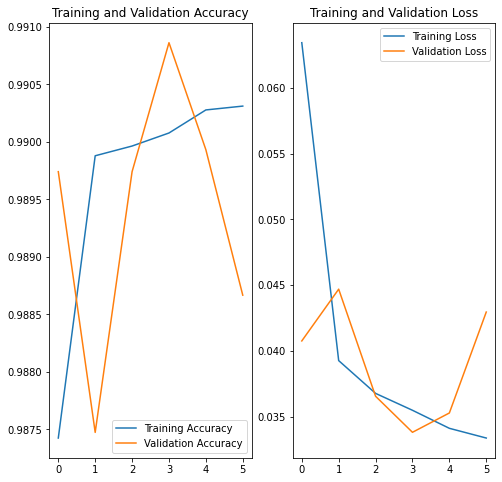

In [16]:
# Define the number of epochs and the early stopping callback
epochs = 10

# Build the model
encoder = autoencoder_mlp.layers[1]
model = build_mlp_model(encoder)

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)

# Plot the training and validation accuracy
# to see if the model is overfitting
epochs_range = range(len(history.history['loss']))
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
mlp_probabilities = model.predict(test_ds)

# Get the predicted class indices
predicted_classes = tf.argmax(mlp_probabilities, axis=1)

# Convert to numpy array for easier inspection
predicted_classes_mlp = predicted_classes.numpy()

# Calculate the metrics of the model
print(classification_report(y_test, predicted_classes_mlp, target_names=classes, zero_division=0, digits=4))

5239/5239 [==============================] - 7s 1ms/step
              precision    recall  f1-score   support

      Benign     0.7721    0.9743    0.8615      3926
        DDoS     0.9990    0.9996    0.9993    121883
         DoS     0.9991    0.9968    0.9980     29199
       Mirai     0.9984    0.9990    0.9987      9583
       Recon     0.8613    0.5153    0.6448      1277
    Spoofing     0.8713    0.6093    0.7171      1766

    accuracy                         0.9907    167634
   macro avg     0.9168    0.8490    0.8699    167634
weighted avg     0.9912    0.9907    0.9901    167634



### MLP baseline

Epoch 1/10
26193/26193 [==============================] - 56s 2ms/step - loss: 0.3830 - accuracy: 0.8390 - val_loss: 0.3613 - val_accuracy: 0.8421
Epoch 2/10
26193/26193 [==============================] - 57s 2ms/step - loss: 0.2444 - accuracy: 0.9244 - val_loss: 0.1338 - val_accuracy: 0.9850
Epoch 3/10
26193/26193 [==============================] - 57s 2ms/step - loss: 0.1333 - accuracy: 0.9824 - val_loss: 0.1309 - val_accuracy: 0.9811
Epoch 4/10
26193/26193 [==============================] - 57s 2ms/step - loss: 0.1239 - accuracy: 0.9832 - val_loss: 0.1128 - val_accuracy: 0.9858
Epoch 5/10
26193/26193 [==============================] - 57s 2ms/step - loss: 0.1179 - accuracy: 0.9835 - val_loss: 0.1053 - val_accuracy: 0.9873
Epoch 6/10
26193/26193 [==============================] - 57s 2ms/step - loss: 0.1153 - accuracy: 0.9835 - val_loss: 0.1075 - val_accuracy: 0.9851
Epoch 7/10
5239/5239 [==============================] - 7s 1ms/step - loss: 0.1033 - accuracy: 0.9874


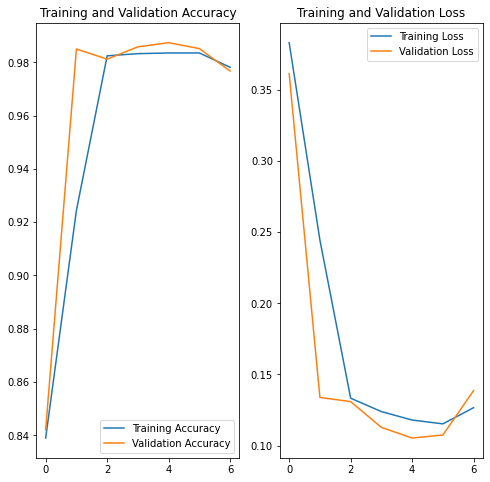

In [18]:
# Define the number of epochs and the early stopping callback
epochs = 10

# Build the model
model = build_mlp_model(tf.keras.layers.DenseFeatures(feature_columns))

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)

# Plot the training and validation accuracy
# to see if the model is overfitting
epochs_range = range(len(history.history['loss']))
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
mlp_probabilities = model.predict(test_ds)

# Get the predicted class indices
predicted_classes = tf.argmax(mlp_probabilities, axis=1)

# Convert to numpy array for easier inspection
predicted_classes_mlp = predicted_classes.numpy()

# Calculate the metrics of the model
print(classification_report(y_test, predicted_classes_mlp, target_names=classes, zero_division=0, digits=4))

5239/5239 [==============================] - 7s 1ms/step
              precision    recall  f1-score   support

      Benign     0.7559    0.9356    0.8362      3926
        DDoS     0.9981    0.9984    0.9983    121883
         DoS     0.9947    0.9940    0.9943     29199
       Mirai     0.9961    0.9897    0.9929      9583
       Recon     0.7271    0.5842    0.6479      1277
    Spoofing     0.8012    0.5136    0.6259      1766

    accuracy                         0.9874    167634
   macro avg     0.8789    0.8359    0.8492    167634
weighted avg     0.9876    0.9874    0.9869    167634

